# Custom bluesky plan

*APS Training for Bluesky Data Acquisition*.

**Objective**

Build a custom plan for an up-down scan using `m2` and `scaler1` channels `I0` and `diode`.  Make the counting time configurable.  Accept user metadata.

## Preparation

First, start the instrument package.

In [1]:
import pathlib, sys
sys.path.append(str(pathlib.Path.home() / "bluesky"))
from instrument.collection import *

/home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Fri-15:54:55 - ############################################################ startup
I Fri-15:54:55 - logging started
I Fri-15:54:55 - logging level = 10
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/session_logs.py
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Fri-15:54:55 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2023_2


Exception reporting mode: Minimal


I Fri-15:54:55 - xmode exception level: 'Minimal'
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py
I Fri-15:54:55 - #### Bluesky Framework ####
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Fri-15:54:55 - RunEngine metadata saved in directory: /home/prjemian/Bluesky_RunEngine_md
I Fri-15:54:55 - using databroker catalog 'training'
I Fri-15:54:55 - using ophyd control layer: pyepics
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Fri-15:54:55 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/epics_signal_conf

## Select scaler channels
The scaler channels are selected by calling its `.select_channels()` method:

In [2]:
scaler1.select_channels(["I0", "diode"])

## Count time
The count time is in the `.preset_time` attribute.  The way to set the scaler with this time is to use ophyd's staging process.  Add `preset_time` to the `.stage_sigs` dictionary with the desired count time as the value.

In [3]:
scaler1.stage_sigs["preset_time"] = 1
scaler1.stage_sigs

OrderedDict([('preset_time', 1)])

# Construct the plan
Create a plan that scans up, then scans down (2 scans total).  Add `temperature` just to get some other interesting data.  We'll add a metadata key for the scan direction.

We'll do this in small steps starting with the innermost part.

In [4]:
def up_down_once(lo, hi, num, md={}):
    dets = [scaler1, temperature]
    _md = {}
    _md.update(md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, lo, hi, num, md=_md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, hi, lo, num, md=_md)

Verify that this code will process through the RunEngine by testing it without running it.  Use the `summarize_plan()` function imported from the `bluesky` package.  This will show the steps of the measurement.

In [5]:
summarize_plan(up_down_once(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================


Next, build a plan that runs this twice.

In [6]:
def up_down_twice(lo, hi, num, md={}):
    for i in range(2):
        yield from up_down_once(lo, hi, num, md=md)

In [7]:
summarize_plan(up_down_twice(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

Finish the custom plan by setting the count time.  Give a default of 1.0 s.

In [8]:
def customScan(lo=0, hi=1, num=5, ct=1, md={}):
    scaler1.stage_sigs["preset_time"] = ct
    _md = {}
    _md.update(md)
    _md["count_time"] = ct
    _md["example"] = "customPlan"

    scaler1.select_channels(["I0", "diode"])
    yield from up_down_twice(lo, hi, num, md=_md)
    scaler1.select_channels()  # reset for all named channels
    del scaler1.stage_sigs["preset_time"]  # remove our custom staging

In [9]:
summarize_plan(customScan(md=dict(demo="concise custom plan example")))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

## Run
Run the `customScan()` plan, using the RunEngine object: `RE()`



Transient Scan ID: 971     Time: 2023-04-14 15:55:48
Persistent Unique Scan ID: '3533adeb-2796-47c7-9c34-c174063ca1bd'
New stream: 'label_start_motor'
New stream: 'primary'
+-----------+------------+------------+-------------+------------+------------+
|   seq_num |       time |         m2 | temperature |         I0 |      diode |
+-----------+------------+------------+-------------+------------+------------+
|         1 | 15:55:50.2 |     0.0000 |    25.18394 |          4 |          4 |
|         2 | 15:55:52.0 |     0.2500 |    24.85393 |          5 |          3 |
|         3 | 15:55:53.8 |     0.5000 |    24.50531 |          5 |          6 |
|         4 | 15:55:55.7 |     0.7500 |    25.21157 |          6 |          5 |
|         5 | 15:55:57.6 |     1.0000 |    25.49052 |          5 |          5 |
+-----------+------------+------------+-------------+------------+------------+
generator scan ['3533adeb'] (scan num: 971)


Transient Scan ID: 972     Time: 2023-04-14 15:55:58
Persis

('3533adeb-2796-47c7-9c34-c174063ca1bd',
 '2f6e0c34-f250-4344-8e5d-776b4a8c12f9',
 '539e7792-04da-4d3c-bb41-937b1779e40f',
 'a697d94a-c398-4285-aeb6-d54d369e051b')

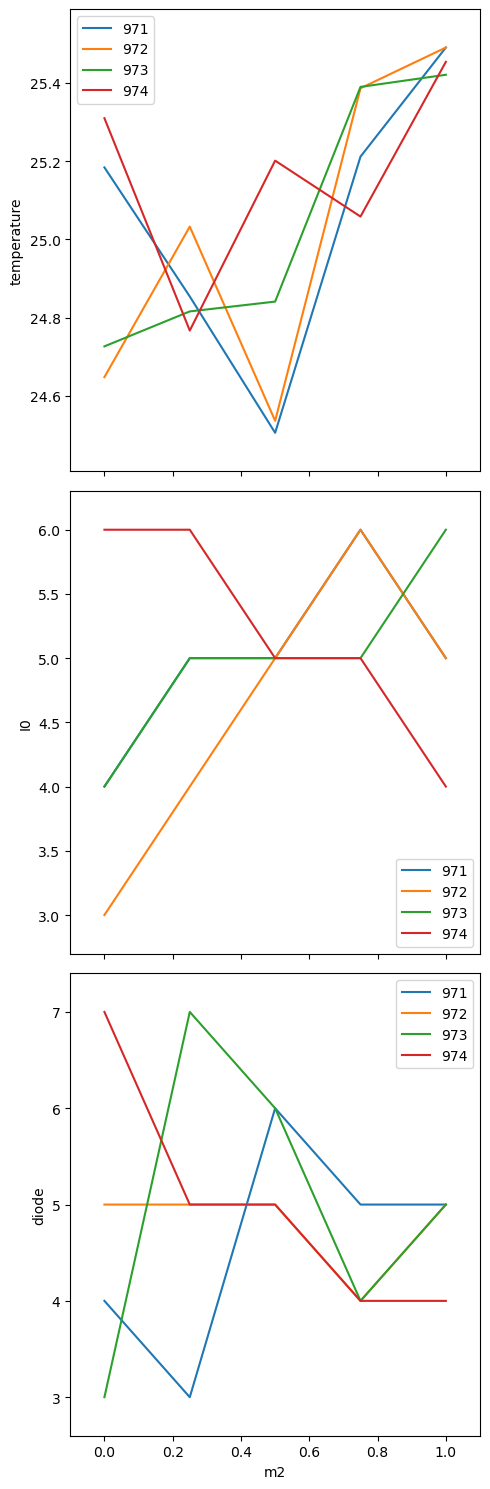

In [9]:
RE(customScan(md=dict(demo="concise custom plan example")))

## Challenges

Make these additions or improvements to the plans:

1. Let the caller specify how many *up*-*down* iterations.
1. Wait between *up* and *down* scans for some time (caller-specified). (hint: `yield from bps.sleep(seconds)`)
1. Use `logger` to report at various places.

   _Hint_: `logger.info("text: %s  value: %g", s1, v2, ...)`

   Consider examples as used in [`peak_finder_example.py`](instrument/plans/peak_finder_example.py).
   See the [Python logging tutorial](https://docs.python.org/3/howto/logging.html) for more information.
1. Control the `shutter` (hint: `yield from bps.mv(shutter, "open")` or `close`)
1. Change the temperature before *up* scan and then before *down* scan.  (hint: `yield from bps.mv(temperature, value)`)